## Rapport sur le TP TITANIC

L'objectif de ce TP est de nous familiariser avec les librairies Pandas et Numpy. Durant ce TP, nous allons essayer de construire un modèle qui nous permettra de prédire le destin d'un passager du Titanic selon différents paramètres (Son nom, sa classe sociale, son age, son sexe, etc...).

On importe d'abord les librairies usuelles pour le traitement et l'analyse de données, à savoir pandas, matplotlib et numpy, puis on charge les données et on les visualise pour être sûr que le DataFrame s'est correctement généré.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
train = pd.read_csv("data/train.csv")
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Dans un second temps, nous visualisons les données plus en détail, en comptant le nombre d'instances de chaque colonnes par exemple.

In [17]:
print(train.count())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64


In [18]:
total = train.shape[0]
print("Nombre de lignes:", train.shape[0])
print("Nombre de colonnes:", train.shape[1])
print("Colonnes:", ", ".join(train.columns))

Nombre de lignes: 891
Nombre de colonnes: 12
Colonnes: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked


On aura remarqué précédemment que certaines lignes contiennent des valeurs manquantes, on peut visualiser leur nombre précisément (voir prochaine cellule)

In [19]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ce sont des données que nous allons devoir traiter, nous allons le faire avant de construire notre modèle.

Afin de créer un modèle avec un taux d'exactitude satisfaisant, il est primordiale de trouver des corrélations entre les paramètres que nous avons et l'issue que nous souhaitons prédire. L'histogramme peut être un excellent outil pour cela. Dans la cellule suivante on présente le nombre de personnes qui ont survécu (en orange) et le nombre de personne qui ont péri (en bleu) selon la classe à laquelle ils appartenaient. On obsèrve ainsi que les 1ères classes ont bénéficié d'une plus grande aide que les passagers issus de la 3ème classe.

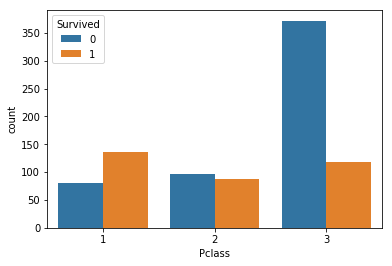

In [20]:
import seaborn as sns
sns.countplot(x='Pclass', hue='Survived', data=train)

La HeatMap de corrélation peut êrte également un bon outil visuel pour visualiser les potentielles corrélations entre nos paramètres et l'issue que l'on souhaite prédire. Ici les données n'ont pas encore été traitées, il apparait donc peu de forte correlation entre les paramètres. Nous comparerons cette heatmap avec une autre une fois que nous aurons traité nos données.

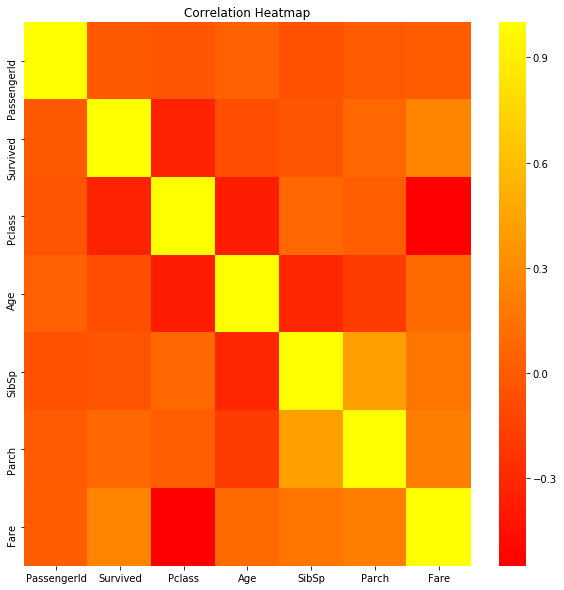

In [21]:
plt.subplots(figsize=(10,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap='autumn')

Traitons nos données. 

- On commence dans un premier temps par 'encoder' le paramètre 'sex' de notre dataset. En effet, il est préférable de traiter des valeurs numériques tels que 1 et 0 pour les données catégorielles. Pour cela, on utilise la classe LabelEncoder de la librairie sklearn.preprocessing. De plus, selon l'histoire, nous pensons que les femmes ont été privilégiés lors du sauvetage.

- On récupère également les valeurs médiane de nos colonnes. Cela va nous permettre de remplacer les valeurs manquantes, pour les données numériques, par leur médiane. C'est une pratique courante et qui va nous permettre de ne pas fausser le modèle. Dans cet exercice, on ne s'en servira que pour remplacer les valeurs manquantes de l'âge des passagers.

- On créer également une nouvelle colonne 'has_cabin', qui est constitué de 1 et de 0 selon qu'un passager était en cabine ou non. Pour cela, on s'appuie sur la colonne 'Cabin' du DataFrame d'origine qui précise le numéro de la cabine du passager. Encore une fois, cette information est exploitable uniquement si on lui donne un sens (tel que les 1 et les 0) interpretable par notre modèle.

- La colonne Embarked présente des valeurs manquantes, mais c'est une donnée catégorielle. Ainsi, on ne la remplacera pas par la "médiane" (ce qui n'a pas de sens pour une donnée catégorielle) mais par son mode, qui est aux données catégorielle ce qu'est la médiane aux données qualitative.

- On uniforme également la colonne Fare

- On créer une nouvelle donnée : FamilySize, qui nous donne la taille de la famille d'un passager.

- La colonne 'isAlone' qui nous précise si un passager était seul ou non à bord du Titanic.

- La colonne 'isChild', car selon l'histoire, nous pensons que les enfants ont été privilégiés lors du sauvetage.

- Enfin, on créer la colonne "Title" qui va classer les passager selon le titre qu'ils occupaient, en récupérant ce titre dans leur nom. En effet, selon leur titre, ils ont pu bénéficier de certains avantages.

In [22]:
from sklearn.preprocessing import LabelEncoder
le_sex = LabelEncoder()
train['sex_encoded'] = le_sex.fit_transform(train.Sex)

median = train.median()
train["Age"].fillna(median["Age"], inplace=True)
train['has_cabin'] = train.Cabin.notnull().astype(int)
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)
train["Fare"] = (train.Fare /20).astype(np.int64) + 1
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['isAlone'] = train['FamilySize'].map(lambda x: 1 if x == 1 else 0)
train["isChild"] = train.Age < 8


train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = train['Title'].replace(
    ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir',
     'Jonkheer', 'Dona'], 'Rare'
)
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train['Title'] = train['Title'].map(title_mapping)


En visualisant maintenant notre nouvelle HeatMap de corrélation, on se rend  compte qu'après un traitement de nos données selon diverses informations et reflexions, nous avons d'avantages de corrélations entre les paramètres que nous avons traité et l'issue que nous voulons prédire (Survived)

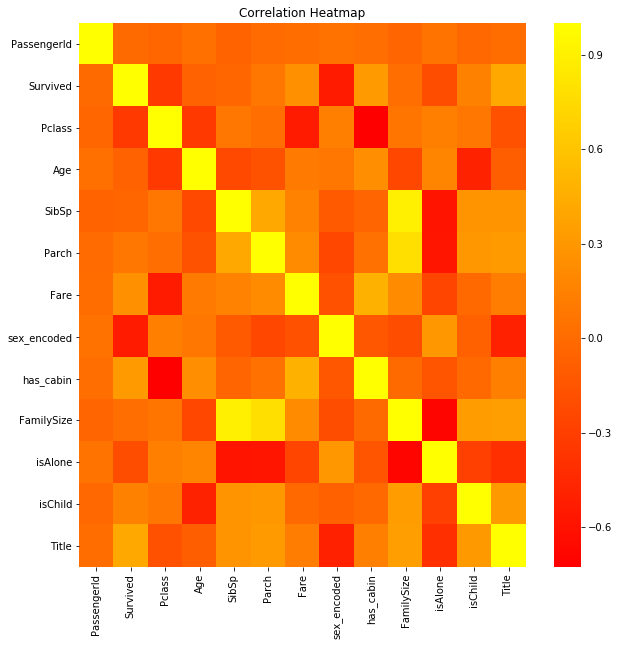

In [23]:
plt.subplots(figsize=(10,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap='autumn')

Il est possible de faire encore mieux, en créant des catégories de certaines de nos colonnes, puisqu'au sein de ces colonnes, il existe des 'groupes' de données qui sont susceptibles d'être fortement corrélés à notre issue, tel que le fait d'être une femme lors du sauvetage par exemple, il faut donc les mettre dans une colonne à part.

In [24]:
train = pd.get_dummies( train, 
                       columns = ["Pclass", "Sex", "Title", "Embarked"])
train.head(10)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,sex_encoded,...,Sex_female,Sex_male,Title_1,Title_2,Title_3,Title_4,Title_5,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,1,NaN,1,...,0,1,1,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,4,C85,0,...,1,0,0,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,1,NaN,0,...,1,0,0,1,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,3,C123,0,...,1,0,0,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,1,NaN,1,...,0,1,1,0,0,0,0,0,0,1
5,6,0,"Moran, Mr. James",28.0,0,0,330877,1,NaN,1,...,0,1,1,0,0,0,0,0,1,0
6,7,0,"McCarthy, Mr. Timothy J",54.0,0,0,17463,3,E46,1,...,0,1,1,0,0,0,0,0,0,1
7,8,0,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,2,NaN,1,...,0,1,0,0,0,1,0,0,0,1
8,9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,1,NaN,0,...,1,0,0,0,1,0,0,0,0,1
9,10,1,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,2,NaN,0,...,1,0,0,0,1,0,0,1,0,0


En visualisant la HeatMap, on se rend compte qu'effectivement, nous obtenons de meileures corrélations.

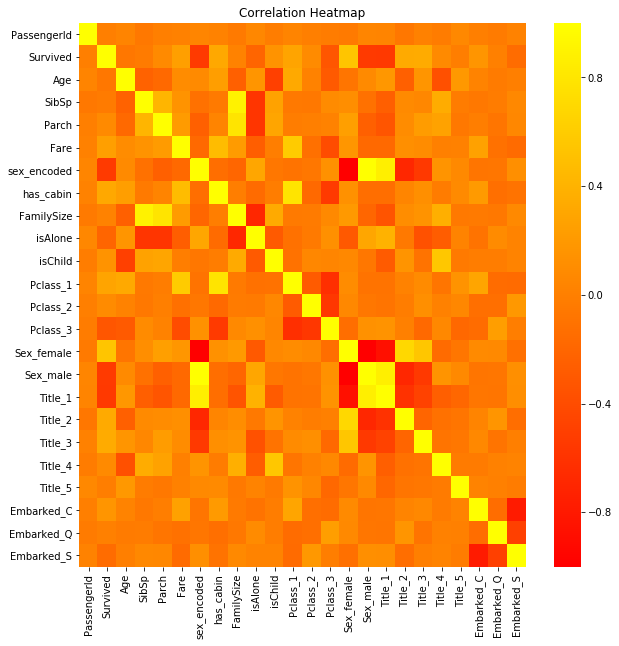

In [25]:
plt.subplots(figsize=(10,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,cmap='autumn')

Dans la suite on expérimente 2 modèles : 

- La regression logistique  :
    
    On va créer une liste 'scores' dans laquelle on va mettre les différents resultats obtenus (pour les différentes tailles de niotre list_test_size) et faire une moyenne de ces scores pour en donner le resultat final
    

- Le Random Forest : 

    On affichera chaque score obtenu en faisant varier deux paramètres : 
    
     - numberarbres : C'est le nombre d'arbres décisionnels utilisés dans le RandomForest.
     - min_leaf : Cela représente le nombre minimum de feuilles que l'on souhaite avoir dans le RandomForest.
        
On remarque que le Random Forest est beaucoup plus performant.

In [26]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

keep = ["Embarked_C", "Embarked_Q", "Embarked_S","has_cabin", "isAlone",
        "FamilySize" , "Fare", "Pclass_1","Pclass_2","Pclass_3", 
        "sex_encoded", "isChild", "Title_1","Title_2","Title_3",
        "Title_4","Title_5"]
list_test_size = [a/20 for a in list(range(20))][1:]
scores = []

for ts in list_test_size:
    X_train, X_test, y_train, y_test = train_test_split(train[keep],
                                                        train["Survived"],
                                                        test_size=ts,
                                                        random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    scores.append(logreg.score(X_test, y_test))

print('Accuracy LogReg: {:.2f}%'.format(np.array(scores).mean()*100))


from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(train[keep],
                                                    train["Survived"],
                                                    test_size=0.05,
                                                    random_state=0)
for numberarbres in range(100, 300, 50):
    for min_leaf in range(8, 20, 1):
        rf = RandomForestClassifier(n_estimators = numberarbres,
                                    min_samples_leaf = min_leaf)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        print('Accuracy RF ({},{}): {:.2f}%'.format(numberarbres,
                                                    min_leaf,
                                                    rf.score(X_test, y_test)*100))

Accuracy LogReg: 81.65%
Accuracy RF (100,8): 84.44%
Accuracy RF (100,9): 86.67%
Accuracy RF (100,10): 84.44%
Accuracy RF (100,11): 86.67%
Accuracy RF (100,12): 84.44%
Accuracy RF (100,13): 86.67%
Accuracy RF (100,14): 84.44%
Accuracy RF (100,15): 86.67%
Accuracy RF (100,16): 84.44%
Accuracy RF (100,17): 84.44%
Accuracy RF (100,18): 84.44%
Accuracy RF (100,19): 84.44%
Accuracy RF (150,8): 86.67%
Accuracy RF (150,9): 84.44%
Accuracy RF (150,10): 86.67%
Accuracy RF (150,11): 86.67%
Accuracy RF (150,12): 86.67%
Accuracy RF (150,13): 86.67%
Accuracy RF (150,14): 84.44%
Accuracy RF (150,15): 86.67%
Accuracy RF (150,16): 84.44%
Accuracy RF (150,17): 84.44%
Accuracy RF (150,18): 84.44%
Accuracy RF (150,19): 84.44%
Accuracy RF (200,8): 86.67%
Accuracy RF (200,9): 86.67%
Accuracy RF (200,10): 86.67%
Accuracy RF (200,11): 86.67%
Accuracy RF (200,12): 86.67%
Accuracy RF (200,13): 86.67%
Accuracy RF (200,14): 86.67%
Accuracy RF (200,15): 86.67%
Accuracy RF (200,16): 84.44%
Accuracy RF (200,17): 86.

De la même manière que précédement, on peut affiner le modèle en créant des catégorie d'âge plutot que de ne vérifier que si le passager est un enfant ou non, ce qui va permettre d'affiner le modèle.

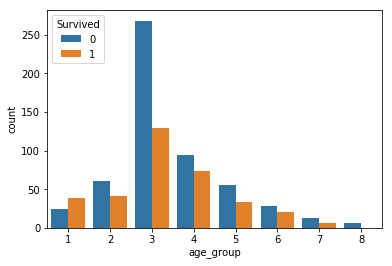

In [27]:
#age_labels = ['0-9', '10-19', '20-29', '30-39','40-49', '50-59', '60-69', '70-79']
age_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
train['age_group'] = pd.cut(train.Age, range(0, 81, 10),
                            right=False, labels=age_labels)
sns.countplot(x=train['age_group'],
              hue='Survived',
              data=train)